In [1]:
import cv2
from imutils import contours
import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import os
from skimage import transform as tr
import numpy as np
from Package.simple_convnet import SimpleConvNet

## Main

In [2]:
class FindCarPlate():
    def __init__(self):
        self.width = 60
        self.height = 80
        
    # Read Photo Image 
    def imageprocess (self, image):
        img = cv2.imread(image) 
        return img
    
    # x_y sobel
    def sobel2(self, img):
        x = cv2.Sobel(img,cv2.CV_16S,1,0)
        y = cv2.Sobel(img,cv2.CV_16S,0,1)

        absX = cv2.convertScaleAbs(x) # 轉回 uint8
        absY = cv2.convertScaleAbs(y)
        dst = cv2.addWeighted(absX,0.5,absY,0.5,0)
        
        dst = dst/np.max(dst)*1000  #加大特徵
        return dst
    
    # Erode and Dilate
    def erodil(self, image):
        a,dst_te = cv2.threshold(image,0,255,cv2.THRESH_BINARY)  #二值化處理
        kernel = np.ones((1,1),np.uint8)  
        erosion = cv2.erode(dst_te,kernel,iterations = 2)  #腐蝕
        kernel = np.ones((1,1),np.uint8)
        dilation = cv2.dilate(erosion,kernel,iterations = 1 )   #膨脹
        
        return dilation
    
    def resize(self, image):
        if image.shape[0] != self.height and image.shape[1] != self.width :
            img = tr.resize(image,[self.height,self.width],order=5)
            #print(image.shape, end=' ==> ')
            #print(img.shape)
        else:
            img = image
        return img
    
    def cropplate(self,img,image):
        cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]   #判斷是哪個版本的 opencv
        cnts, _ = contours.sort_contours(cnts, method="left-to-right")   #由左到右排序輪廓
        
        return result

In [3]:
def main1(img):
    img1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img1 = cv2.GaussianBlur(img1,(3,3),10)   #高斯模糊
    dst = step1.sobel2(img1)                   #做兩次 sobel
    ret,thresh2 = cv2.threshold(dst,127,255,0)           #二值化
    thresh = cv2.threshold(thresh2,0,255,cv2.THRESH_BINARY)[1]
    thresh = step1.erodil(thresh)             #做腐蝕+膨脹
    thresh = np.array(thresh,np.uint8)     #格式轉換

    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]   #判斷是哪個版本的 opencv
    cnts, _ = contours.sort_contours(cnts, method="left-to-right")   #由左到右排序輪廓


    
    ROI =  img # 如果沒有找到 就預設是整張照片
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)


        # Find carplate
        if area> img.shape[0]*img.shape[1]/22 and w>h and h*3>w  :
            ROI =  img[y:y+h, x:x+w]
            cv2.rectangle(img, (x, y), (x + w, y + h), (255,255,255), 2)
    return ROI

In [4]:
def main2(ROI):
    image = ROI
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #dst = step1.sobel2(gray)                   #做兩次 sobel
    ret,thresh2 = cv2.threshold(gray,127,255,0)           #二值化
    thresh = cv2.threshold(thresh2,0,255,cv2.THRESH_BINARY)[1]
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.dilate(thresh,kernel,iterations = 1 )   #膨脹
    thresh = np.array(thresh,np.uint8)     #格式轉換
    thresh = thresh-255

    # Find contours, sort from left-to-right, then crop
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   # <=== find contour
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts, _ = contours.sort_contours(cnts, method="left-to-right")   # <== 從左到右排序圖片
    
    plot = []
    for c in cnts:
        area = cv2.contourArea(c)  # Calculation Contour Area
        x,y,w,h = cv2.boundingRect(c)
        if area> ROI.shape[0]*ROI.shape[1]/500 and w<h and w*15>h :   
            x,y,w,h = cv2.boundingRect(c)
            ROI2 = image[y-5:y+h+5, x-3:x+w+3]
            #如果邊緣太過邊邊的應對方式
            try:
                ROI2 = step1.resize(ROI2)
                plot.append(ROI2)
            except ValueError:
                ROI2 = image[y:y+h, x:x+w]
                ROI2 = step1.resize(ROI2)
                plot.append(ROI2)
            

            #cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0, 2))
    return plot

In [5]:
def image_read(img,normalize=True,flatten=False):      
    # 如果 尺寸不對 就做調整 
    if img.shape[0] != 32 and img.shape[1] !=32 :
        img=tr.resize(img,[32,32],order=5)
        container=img.flatten()
    else:
        container=img.flatten()
    
    #print(container.shape)
    
    if (normalize == False) and (container.dtype != 'uint8'):
        container=(container).astype(np.uint8)
    else:   
        container=container.astype(np.float32)   
    
    ''' qui num-1 ? '''
    if flatten != True :
        container=container.reshape(32,32)    

    return container

## Network

In [6]:
#初始化網路和參數
network = SimpleConvNet(input_dim=(1,32,32), 
                        conv_param = {'filter_num': 35, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=150, output_size=35, weight_init_std=0.01)

In [7]:
network.load_params("Carplate_Converlution_weight.pkl")       
print("Saved Network Parameters!")

Saved Network Parameters!


# Include

In [8]:
# 找到路徑下的所有圖片
Path =  './ACC/'
allFile = os.listdir(Path)
print(allFile)
step1 = FindCarPlate()

mypath = "Tranum"
allabel = os.listdir('./'+mypath) #標籤紀錄

['AM8159.png', 'carplate1.png', 'carplate11.png', 'carplate12.png', 'carplate13.png', 'carplate15.png', 'carplate16.png', 'carplate17.png', 'carplate18.png', 'carplate19.png', 'carplate2.png', 'carplate20.png', 'carplate21.png', 'carplate22.png', 'carplate23.png', 'carplate24.png', 'carplate25.png', 'carplate26.png', 'carplate28.png', 'carplate29.png', 'carplate3.png', 'carplate30.png', 'carplate33.png', 'carplate34.png', 'carplate4.png', 'carplate5.png', 'carplate6.png', 'carplate7.png', 'carplate8.png', 'carplate9.png', 'test1.png', 'test12.png', 'test13.png', 'test14.png', 'test15.png', 'test16.png', 'test17.png', 'test19.png', 'test2.png', 'test21.png', 'test22.png', 'test23.png', 'test24.png', 'test25.png', 'test26.png', 'test27.png', 'test28.png', 'test3.png', 'test31.png', 'test32.png', 'test33.png', 'test34.png', 'test35.png', 'test36.png', 'test37.png', 'test38.png', 'test4.png', 'test40.png', 'test41.png', 'test43.png', 'test45.png', 'test46.png', 'test5.png', 'test6.png', 't

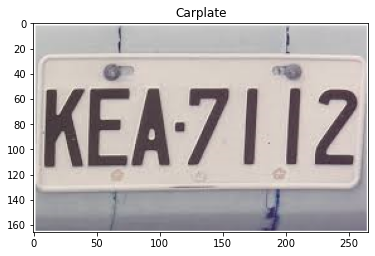

carplate：K E A 7 1 1 2 

In [10]:
img = cv2.imread(Path +allFile[5])
ROI = main1(img)  # Find Carplate
#ROI = main1(ROI)  # Find Carplate
plt.imshow(ROI)
plt.title('Carplate')
plt.show() 


ROI_Num = main2(ROI)                # Num Crop
#f, axarr = plt.subplots(1, len(ROI_Num), figsize=(20, 5*len(ROI_Num)))

times = 0
print('carplate',end='：')
for a in range(len(ROI_Num)):
    times += 1
    gray = cv2.cvtColor(ROI_Num[a].astype(np.float32), cv2.COLOR_BGR2GRAY)
    x = image_read(gray)
    x = np.array(x).reshape(1,1,32,32)
    #plt.imshow(array2img((gray*255))) # No flatten
    #plt.show()
    y= network.predict(x)
    p= np.argmax(y) # obtain index value of the highest prediction result 
    
    print(allabel[p],end=' ')